# Imports

In [1]:
# Import standard libraries
import csv
import OmicsIntegrator as oi
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import pickle
import tqdm
import time

# Import custom libraries
import drugs2
import prizes
import sensitivity_analysis as sensitivity
import sensitivity_sarspartners as svp
import neighborhoods as nbh

# Create prized list

## Selected aging genes

In [2]:
aging_rnaseq_data_file_name = '../Data/GTEX_log2_RPKMquantile.csv'
metadata_file_name = '../Data/metadata.csv.gz'
protein_coding_genes_file_name = '../Data/protein_coding_ensembl_gene_id_hgnc_hg19.txt'
gtex_rpkm_selected_df = prizes.load_selected_aging_rnaseq_data(aging_rnaseq_data_file_name,
                                                               metadata_file_name,
                                                               protein_coding_genes_file_name)
gtex_rpkm_selected_df.head()

,name,mean_treatment,mean_control,log2FC,abslog2FC
1639,ROS1,3.483151,13.566431,-1.700063,1.700063
2385,F8,8.505311,2.139793,1.598064,1.598064
4922,NTRK2,2.866247,0.303249,1.568821,1.568821
11846,HBQ1,2.723305,0.322290,1.493545,1.493545
5321,FRZB,9.709402,2.959846,1.435362,1.435362


## Selected Blanco et al. genes

In [3]:
# First load and process data from Blanco et al.
blanco_data_file_name = '../Data/GSE147507_log2_RPKMquantile.csv'
blanco1_rpkm, blanco2_rpkm, blanco3_rpkm = prizes.load_and_process_blanco_data(blanco_data_file_name, 
                                                                               protein_coding_genes_file_name)

In [4]:
# Then compute selected genes from Blanco et al.
blanco_rpkm_selected = prizes.load_selected_blanco_genes(  blanco1_rpkm,
                                                           blanco2_rpkm,
                                                           blanco3_rpkm,
                                                           protein_coding_genes_file_name,
                                                           plot_venn_diagrams=False)
blanco_rpkm_selected.head()

,name,Series16_A549.ACE2_Mock_1,Series16_A549.ACE2_Mock_2,Series16_A549.ACE2_Mock_3,Series16_A549.ACE2_SARS.CoV.2_1,Series16_A549.ACE2_SARS.CoV.2_2,Series16_A549.ACE2_SARS.CoV.2_3,mean_treatment,mean_control,log2FC,abslog2FC
16,MRPL20,23.476467,21.996085,22.725973,10.491229,10.301154,9.132030,9.974804,22.732841,-1.112690,1.112690
31,FAM213B,5.360438,3.903674,3.700970,1.084121,0.474477,1.628909,1.062502,4.321694,-1.367490,1.367490
34,TPRG1L,20.528304,19.654982,21.892141,8.881052,8.683763,7.923967,8.496260,20.691809,-1.191719,1.191719
41,KCNAB2,3.732427,2.494125,2.801351,0.308315,0.553297,0.147803,0.336471,3.009301,-1.584922,1.584922
44,ICMT,21.144779,22.122032,20.299840,8.961928,6.999973,9.068861,8.343587,21.188884,-1.247789,1.247789


## Create final prized list

In [5]:
# Load L1000 gene list
lincs_genes_file_name = '../Data/GSE92742_Broad_LINCS_gene_info.txt'
l1000_genes = prizes.load_lincs_genes(lincs_genes_file_name)

# Load proteins in ppi list
ppi_data_file_name = '../Data/iRefIndex_v14_MIScore_interactome_C9.costs.allcaps.txt'
proteins_in_ppi = prizes.load_iref_genes(ppi_data_file_name)

In [6]:
terminal_df = prizes.create_prized_genes_list(blanco2_rpkm,
                                     blanco_rpkm_selected,
                                     gtex_rpkm_selected_df,
                                     l1000_genes,
                                     proteins_in_ppi,
                                     plot_venn_diagrams=False)
terminal_df.head(10)

,name,prize,log2FC_blanco,log2FC_ageing
0,ACAT1,1.203090,-1.203090,-0.509400
2,ADK,1.186245,-1.186245,-0.568995
3,AGA,1.590582,-1.590582,-0.404011
4,AIFM1,1.418865,-1.418865,-0.454493
5,ALDH1B1,1.478519,-1.478519,-0.438291
6,ALG1,1.302155,-1.302155,-0.365349
7,APEH,1.403288,-1.403288,-0.476856
8,ARL4D,1.474380,1.474380,0.570956
10,ATIC,1.304655,-1.304655,-0.417875
12,AURKC,1.207711,1.207711,0.452153


In [7]:
# Save terminal df to tsv
terminal_df.to_csv(r'../Save_drop1/terminals_ppi_analysis.tsv', header=True, index=None, sep='\t', quoting = csv.QUOTE_NONE, escapechar = '\t')

# Prepare the sentivity analysis for Stein tree parameters

## W range

In [8]:
# Load prizes data
prizes_data = terminal_df
terminals = list(prizes_data['name'])
n_terminals = len(terminals)

In [9]:
# Load IREF interactome
interactome_file = "../Data/iRefIndex_v14_MIScore_interactome_C9.costs.allcaps.txt"
graph = oi.Graph(interactome_file)

In [59]:
# Distribution of cheapest path between any two terminals without penalty (g=-\infty)
network = graph.interactome_graph
shortest_dist_mat = np.zeros(shape = (n_terminals,n_terminals))
for ix_prot1 in tqdm.tqdm(np.arange(n_terminals)):
    time.sleep(0.01)
    for ix_prot2 in np.arange(ix_prot1+1, n_terminals, 1):
        shortest_dist_mat[ix_prot1,ix_prot2] = nx.dijkstra_path_length(network,
                                                                       source = terminals[ix_prot1],
                                                                       target = terminals[ix_prot2],
                                                                       weight = 'cost')
        shortest_dist_mat[ix_prot2,ix_prot2] = shortest_dist_mat[ix_prot1,ix_prot2]

100%|██████████| 162/162 [38:54<00:00, 14.41s/it] 


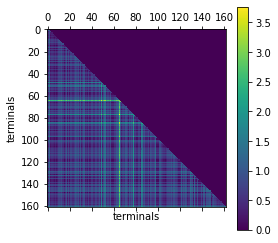

In [63]:
# Plot heatmap of cheapest path
plt.matshow(np.transpose(shortest_dist_mat))
plt.xlabel('terminals')
plt.ylabel('terminals')
plt.colorbar()

Text(0, 0.5, 'Number of pairs of terminals')

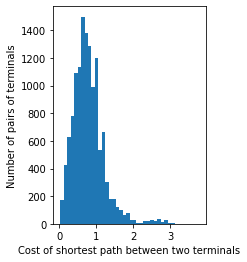

In [64]:
# Plot histogram of cheapest path
plt.subplot(1,2,1)
flat_mat = shortest_dist_mat[np.triu_indices(n_terminals, k=1)]
plt.hist(flat_mat,40)
plt.xlabel('Cost of shortest path between two terminals')
plt.ylabel('Number of pairs of terminals')

## G range

In [10]:
# Create a dictionary containing edge costs under several choices of g
g_range = [0,1,2,3,4,5]
edge_costs_dict={'g = -Inf': graph.edge_costs}
for g in g_range:
    params = {"w": 0, "b": 1, "g": g, "edge_noise": 0, "dummy_mode": "terminals", "seed": 0, "skip_checks": False}
    graph._reset_hyperparameters(params)
    edge_costs_dict['g='+str(g)] = graph.costs
edge_costs_df = pd.DataFrame(data = edge_costs_dict)

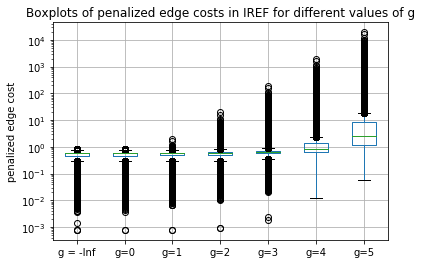

In [11]:
# Boxplot of edge costs under several choices of g
plt.figure()
edge_costs_df.boxplot()
plt.yscale('log')
plt.ylabel('penalized edge cost')
plt.title('Boxplots of penalized edge costs in IREF for different values of g')
plt.show()

## B range

In [12]:
# For a range of g, compute the maximum penalized edge cost
g_range = [0,1,2,3,4,5]
max_penalized_edge_cost = pd.DataFrame(edge_costs_df.max())
max_penalized_edge_cost.columns=['max_penalized_edge_cost']
max_penalized_edge_cost

,max_penalized_edge_cost
g = -Inf,0.859220
g=0,0.860892
g=1,2.015303
g=2,19.487738
g=3,194.212079
g=4,1941.455488
g=5,19413.889586


# Sensitivity analysis for Steiner tree parameters

## Run sensitivity analysis

In [13]:
# Load set of virus interacting genes from Gordon et al.
virus_partners_file_name = "../Data/SARSCov_targets_df.tsv"
virus_interacting_genes = sensitivity.import_virus_partners(virus_partners_file_name)

In [14]:
# Parameters for sensitivity analysis
interactome_file_name = "../Data/iRefIndex_v14_MIScore_interactome_C9.costs.allcaps.txt"
prize_file_name = "../Save_drop1/terminals_ppi_analysis.tsv"
# Graph hyperparameters
graph_params =  {
                "noise": 0.0, 
                "dummy_mode": "terminals", 
                "exclude_terminals": False, 
                "seed": 1,
                "pruning": 'strong',
                "verbosity_level": 0
                }
# Set sweeping parameters, i.e. configurations (w,b,g)
W_list = np.linspace(start = 0.2, stop = 2, num = 10)
B_list = np.array([5., 10., 15., 20., 25., 30., 35., 40., 45., 50.])

In [15]:
# Run sensitivity analysis
networks_dict = sensitivity.run_sensitivity_analysis(interactome_file_name, 
                                                     prize_file_name, 
                                                     graph_params, 
                                                     W_list, 
                                                     B_list, 
                                                     G=0)

05:24:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:28 - OI2: INFO - []
05:24:28 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:28 - OI2: INFO - []


Progress= 0.01


05:24:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:29 - OI2: INFO - []
05:24:29 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:29 - OI2: INFO - []


Progress= 0.02


05:24:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:30 - OI2: INFO - []
05:24:30 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:30 - OI2: INFO - []


Progress= 0.03


05:24:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:31 - OI2: INFO - []
05:24:31 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:31 - OI2: INFO - []


Progress= 0.04


05:24:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:32 - OI2: INFO - []
05:24:32 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:32 - OI2: INFO - []


Progress= 0.05


05:24:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:33 - OI2: INFO - []
05:24:33 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:33 - OI2: INFO - []


Progress= 0.06


05:24:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:34 - OI2: INFO - []
05:24:34 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:34 - OI2: INFO - []


Progress= 0.07


05:24:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:35 - OI2: INFO - []
05:24:35 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:35 - OI2: INFO - []


Progress= 0.08


05:24:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:36 - OI2: INFO - []
05:24:36 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:36 - OI2: INFO - []


Progress= 0.09


05:24:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:37 - OI2: INFO - []
05:24:37 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:37 - OI2: INFO - []


Progress= 0.1


05:24:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:38 - OI2: INFO - []
05:24:38 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:38 - OI2: INFO - []


Progress= 0.11


05:24:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:39 - OI2: INFO - []
05:24:39 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:39 - OI2: INFO - []


Progress= 0.12


05:24:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:40 - OI2: INFO - []
05:24:40 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:40 - OI2: INFO - []


Progress= 0.13


05:24:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:41 - OI2: INFO - []
05:24:41 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:41 - OI2: INFO - []


Progress= 0.14


05:24:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:43 - OI2: INFO - []
05:24:43 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:43 - OI2: INFO - []


Progress= 0.15


05:24:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:44 - OI2: INFO - []
05:24:44 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:44 - OI2: INFO - []


Progress= 0.16


05:24:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:45 - OI2: INFO - []
05:24:45 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:45 - OI2: INFO - []


Progress= 0.17


05:24:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:46 - OI2: INFO - []
05:24:46 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:46 - OI2: INFO - []


Progress= 0.18


05:24:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:47 - OI2: INFO - []
05:24:47 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:47 - OI2: INFO - []


Progress= 0.19


05:24:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:49 - OI2: INFO - []
05:24:49 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:49 - OI2: INFO - []


Progress= 0.2


05:24:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:50 - OI2: INFO - []
05:24:50 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:50 - OI2: INFO - []


Progress= 0.21


05:24:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:51 - OI2: INFO - []
05:24:51 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:51 - OI2: INFO - []


Progress= 0.22


05:24:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:53 - OI2: INFO - []
05:24:53 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:53 - OI2: INFO - []


Progress= 0.23


05:24:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:54 - OI2: INFO - []
05:24:54 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:54 - OI2: INFO - []


Progress= 0.24


05:24:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:55 - OI2: INFO - []
05:24:55 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:55 - OI2: INFO - []


Progress= 0.25


05:24:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:57 - OI2: INFO - []
05:24:57 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:57 - OI2: INFO - []


Progress= 0.26


05:24:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:58 - OI2: INFO - []
05:24:58 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:58 - OI2: INFO - []


Progress= 0.27


05:24:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:59 - OI2: INFO - []
05:24:59 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:59 - OI2: INFO - []


Progress= 0.28


05:25:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:01 - OI2: INFO - []
05:25:01 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:01 - OI2: INFO - []


Progress= 0.29


05:25:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:02 - OI2: INFO - []
05:25:02 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:02 - OI2: INFO - []


Progress= 0.3


05:25:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:03 - OI2: INFO - []
05:25:03 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:03 - OI2: INFO - []


Progress= 0.31


05:25:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:05 - OI2: INFO - []
05:25:05 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:05 - OI2: INFO - []


Progress= 0.32


05:25:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:06 - OI2: INFO - []
05:25:06 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:06 - OI2: INFO - []


Progress= 0.33


05:25:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:07 - OI2: INFO - []
05:25:07 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:07 - OI2: INFO - []


Progress= 0.34


05:25:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:09 - OI2: INFO - []
05:25:09 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:09 - OI2: INFO - []


Progress= 0.35


05:25:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:10 - OI2: INFO - []
05:25:10 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:10 - OI2: INFO - []


Progress= 0.36


05:25:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:11 - OI2: INFO - []
05:25:11 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:11 - OI2: INFO - []


Progress= 0.37


05:25:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:13 - OI2: INFO - []
05:25:13 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:13 - OI2: INFO - []


Progress= 0.38


05:25:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:14 - OI2: INFO - []
05:25:14 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:14 - OI2: INFO - []


Progress= 0.39


05:25:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:15 - OI2: INFO - []
05:25:15 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:15 - OI2: INFO - []


Progress= 0.4


05:25:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:17 - OI2: INFO - []
05:25:17 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:17 - OI2: INFO - []


Progress= 0.41


05:25:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:18 - OI2: INFO - []
05:25:18 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:18 - OI2: INFO - []


Progress= 0.42


05:25:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:19 - OI2: INFO - []
05:25:19 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:19 - OI2: INFO - []


Progress= 0.43


05:25:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:21 - OI2: INFO - []
05:25:21 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:21 - OI2: INFO - []


Progress= 0.44


05:25:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:22 - OI2: INFO - []
05:25:22 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:22 - OI2: INFO - []


Progress= 0.45


05:25:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:24 - OI2: INFO - []
05:25:24 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:24 - OI2: INFO - []


Progress= 0.46


05:25:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:25 - OI2: INFO - []
05:25:25 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:25 - OI2: INFO - []


Progress= 0.47


05:25:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:26 - OI2: INFO - []
05:25:26 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:26 - OI2: INFO - []


Progress= 0.48


05:25:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:28 - OI2: INFO - []
05:25:28 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:28 - OI2: INFO - []


Progress= 0.49


05:25:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:29 - OI2: INFO - []
05:25:29 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:29 - OI2: INFO - []


Progress= 0.5


05:25:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:30 - OI2: INFO - []
05:25:30 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:30 - OI2: INFO - []


Progress= 0.51


05:25:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:32 - OI2: INFO - []
05:25:32 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:32 - OI2: INFO - []


Progress= 0.52


05:25:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:33 - OI2: INFO - []
05:25:33 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:33 - OI2: INFO - []


Progress= 0.53


05:25:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:34 - OI2: INFO - []
05:25:34 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:34 - OI2: INFO - []


Progress= 0.54


05:25:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:36 - OI2: INFO - []
05:25:36 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:36 - OI2: INFO - []


Progress= 0.55


05:25:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:37 - OI2: INFO - []
05:25:37 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:37 - OI2: INFO - []


Progress= 0.56


05:25:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:39 - OI2: INFO - []
05:25:39 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:39 - OI2: INFO - []


Progress= 0.57


05:25:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:40 - OI2: INFO - []
05:25:40 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:40 - OI2: INFO - []


Progress= 0.58


05:25:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:41 - OI2: INFO - []
05:25:41 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:41 - OI2: INFO - []


Progress= 0.59


05:25:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:43 - OI2: INFO - []
05:25:43 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:43 - OI2: INFO - []


Progress= 0.6


05:25:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:44 - OI2: INFO - []
05:25:44 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:44 - OI2: INFO - []


Progress= 0.61


05:25:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:45 - OI2: INFO - []
05:25:45 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:45 - OI2: INFO - []


Progress= 0.62


05:25:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:47 - OI2: INFO - []
05:25:47 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:47 - OI2: INFO - []


Progress= 0.63


05:25:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:48 - OI2: INFO - []
05:25:48 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:48 - OI2: INFO - []


Progress= 0.64


05:25:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:50 - OI2: INFO - []
05:25:50 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:50 - OI2: INFO - []


Progress= 0.65


05:25:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:51 - OI2: INFO - []
05:25:51 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:51 - OI2: INFO - []


Progress= 0.66


05:25:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:52 - OI2: INFO - []
05:25:52 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:52 - OI2: INFO - []


Progress= 0.67


05:25:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:54 - OI2: INFO - []
05:25:54 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:54 - OI2: INFO - []


Progress= 0.68


05:25:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:55 - OI2: INFO - []
05:25:55 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:55 - OI2: INFO - []


Progress= 0.69


05:25:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:57 - OI2: INFO - []
05:25:57 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:57 - OI2: INFO - []


Progress= 0.7


05:25:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:58 - OI2: INFO - []
05:25:58 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:58 - OI2: INFO - []


Progress= 0.71


05:25:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:59 - OI2: INFO - []
05:25:59 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:59 - OI2: INFO - []


Progress= 0.72


05:26:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:01 - OI2: INFO - []
05:26:01 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:01 - OI2: INFO - []


Progress= 0.73


05:26:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:03 - OI2: INFO - []
05:26:03 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:03 - OI2: INFO - []


Progress= 0.74


05:26:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:04 - OI2: INFO - []
05:26:04 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:04 - OI2: INFO - []


Progress= 0.75


05:26:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:06 - OI2: INFO - []
05:26:06 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:06 - OI2: INFO - []


Progress= 0.76


05:26:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:07 - OI2: INFO - []
05:26:07 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:07 - OI2: INFO - []


Progress= 0.77


05:26:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:08 - OI2: INFO - []
05:26:08 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:08 - OI2: INFO - []


Progress= 0.78


05:26:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:10 - OI2: INFO - []
05:26:10 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:10 - OI2: INFO - []


Progress= 0.79


05:26:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:11 - OI2: INFO - []
05:26:11 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:11 - OI2: INFO - []


Progress= 0.8


05:26:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:12 - OI2: INFO - []
05:26:12 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:12 - OI2: INFO - []


Progress= 0.81


05:26:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:14 - OI2: INFO - []
05:26:14 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:14 - OI2: INFO - []


Progress= 0.82


05:26:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:15 - OI2: INFO - []
05:26:15 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:15 - OI2: INFO - []


Progress= 0.83


05:26:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:16 - OI2: INFO - []
05:26:16 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:16 - OI2: INFO - []


Progress= 0.84


05:26:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:18 - OI2: INFO - []
05:26:18 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:18 - OI2: INFO - []


Progress= 0.85


05:26:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:19 - OI2: INFO - []
05:26:19 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:19 - OI2: INFO - []


Progress= 0.86


05:26:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:21 - OI2: INFO - []
05:26:21 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:21 - OI2: INFO - []


Progress= 0.87


05:26:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:22 - OI2: INFO - []
05:26:22 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:22 - OI2: INFO - []


Progress= 0.88


05:26:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:23 - OI2: INFO - []
05:26:23 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:23 - OI2: INFO - []


Progress= 0.89


05:26:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:25 - OI2: INFO - []
05:26:25 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:25 - OI2: INFO - []


Progress= 0.9


05:26:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:26 - OI2: INFO - []
05:26:26 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:26 - OI2: INFO - []


Progress= 0.91


05:26:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:27 - OI2: INFO - []
05:26:27 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:27 - OI2: INFO - []


Progress= 0.92


05:26:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:29 - OI2: INFO - []
05:26:29 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:29 - OI2: INFO - []


Progress= 0.93


05:26:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:30 - OI2: INFO - []
05:26:30 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:30 - OI2: INFO - []


Progress= 0.94


05:26:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:32 - OI2: INFO - []
05:26:32 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:32 - OI2: INFO - []


Progress= 0.95


05:26:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:33 - OI2: INFO - []
05:26:33 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:33 - OI2: INFO - []


Progress= 0.96


05:26:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:34 - OI2: INFO - []
05:26:34 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:34 - OI2: INFO - []


Progress= 0.97


05:26:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:36 - OI2: INFO - []
05:26:36 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:36 - OI2: INFO - []


Progress= 0.98


05:26:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:37 - OI2: INFO - []
05:26:37 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:37 - OI2: INFO - []


Progress= 0.99


05:26:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:38 - OI2: INFO - []
05:26:38 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:38 - OI2: INFO - []


Progress= 1.0


In [16]:
# Save as pickle
with open("../Save_drop1/networks_dict.pkl", "wb") as f: 
    pickle.dump(networks_dict, f)

In [15]:
# Add metatadata
networks_dict = pickle.load(open("../Save_drop1/networks_dict.pkl", "rb"))
networks_dict = sensitivity.add_metadata(networks_dict, virus_interacting_genes)

In [16]:
# Make summary
networks_summary_df = sensitivity.make_summary(networks_dict, n_terminals, g=0)
networks_summary_df.head()

,index,w,b,g,nodes,edges,number_components,size_components,percentage_terminals,upregulated_terminals,downregulated_terminals,number_transcription_regulators,transcription_regulators,number_of_proteins_interacting_sars,proteins_interacting_sars
w_0.2_b_10.0,1,0.2,10.0,0,187,357,33,"[155, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",1.0,75,87,5,"[CREB5, ETV6, HOXB3, IRF2, TSC22D2]",3,"[EXOSC5, FOXRED2, LOX]"
w_0.2_b_15.0,2,0.2,15.0,0,187,357,33,"[155, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",1.0,75,87,5,"[CREB5, ETV6, HOXB3, IRF2, TSC22D2]",3,"[EXOSC5, FOXRED2, LOX]"
w_0.2_b_20.0,3,0.2,20.0,0,187,357,33,"[155, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",1.0,75,87,5,"[CREB5, ETV6, HOXB3, IRF2, TSC22D2]",3,"[EXOSC5, FOXRED2, LOX]"
w_0.2_b_25.0,4,0.2,25.0,0,187,357,33,"[155, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",1.0,75,87,5,"[CREB5, ETV6, HOXB3, IRF2, TSC22D2]",3,"[EXOSC5, FOXRED2, LOX]"
w_0.2_b_30.0,5,0.2,30.0,0,187,357,33,"[155, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",1.0,75,87,5,"[CREB5, ETV6, HOXB3, IRF2, TSC22D2]",3,"[EXOSC5, FOXRED2, LOX]"


## Plot node stability heatmaps

<Figure size 432x288 with 0 Axes>

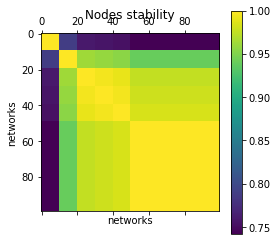

In [19]:
# Stability of selected nodes
mat_allnodes = sensitivity.create_matrix_gene_overlap_between_networks(networks_summary_df, networks_dict)
plt.figure()
plt.matshow(mat_allnodes)
plt.xlabel('networks')
plt.ylabel('networks')
plt.title('Nodes stability')
plt.colorbar()
plt.show()

<Figure size 432x288 with 0 Axes>

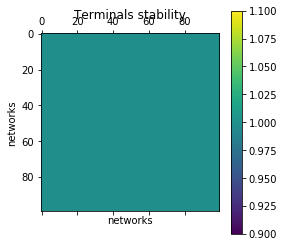

In [20]:
# Stability of selected terminals
mat_terminals = sensitivity.create_matrix_terminal_overlap_between_networks(networks_summary_df, networks_dict)
plt.figure()
plt.matshow(mat_terminals)
plt.xlabel('networks')
plt.ylabel('networks')
plt.title('Terminals stability')
plt.colorbar()
plt.show()

<Figure size 432x288 with 0 Axes>

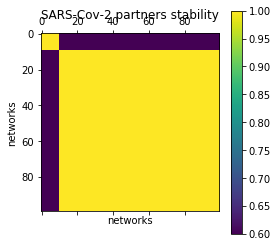

In [21]:
# Stability of selected SARS-Cov-2 partners
mat_sars = sensitivity.create_matrix_sars_overlap_between_networks(networks_summary_df, networks_dict)
plt.figure()
plt.matshow(mat_sars)
plt.xlabel('networks')
plt.ylabel('networks')
plt.title('SARS-Cov-2 partners stability')
plt.colorbar()
plt.show()

## Select robust parameters

In [17]:
# Select network corresponding to g=0, w=1.4 and b=40
index_selected = 67
paramstring_selected = networks_summary_df[networks_summary_df['index']==index_selected].index[0]
network_selected = networks_dict[paramstring_selected]

In [18]:
# Save selected network to file
oi.output_networkx_graph_as_interactive_html(network_selected, filename="../Save_drop1/network_selected.html")
oi.output_networkx_graph_as_pickle(network_selected, filename= '../Save_drop1/network_selected.pickle')
#oi.output_networkx_graph_as_graphml_for_cytoscape(robust_network, filename= '../Save_drop1/network_selected.graphml')

PosixPath('/home/louiscam/projects/sars_cov_2/Save_drop1/network_selected.pickle')

# Sensitivity analysis for virus partners prize

## Run sensitivity analysis

In [27]:
# Identify which SARS-Cov-2 partners are in the terminal list
terminal_partners = set(terminals).intersection(virus_interacting_genes)
print(terminal_partners)

{'LOX', 'FOXRED2', 'EXOSC5'}


In [28]:
# Run sensitivity analysis
interactome_file_name = "../Data/iRefIndex_v14_MIScore_interactome_C9.costs.allcaps.txt"
prize_file_name = "../Save_drop1/terminals_ppi_analysis.tsv"
# Graph hyperparameters
graph_params =  {
                "noise": 0.0, 
                "dummy_mode": "terminals", 
                "exclude_terminals": False, 
                "seed": 1,
                "pruning": 'strong',
                "verbosity_level": 0,
                "w": 1.4,
                "b": 40,
                "g": 0
                }
# List of values of P
P_list = np.arange(0,0.0016,0.0001)

networks_dict = svp.run_prize_sensitivity_analysis(interactome_file_name, 
                                                   prize_file_name, 
                                                   graph_params, 
                                                   virus_interacting_genes, 
                                                   terminal_partners, 
                                                   P_list)

11:40:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:40:50 - OI2: INFO - []
11:40:50 - OI2: INFO - Members of the prize file not present in the interactome:
11:40:50 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.0625


11:40:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:40:52 - OI2: INFO - []
11:40:52 - OI2: INFO - Members of the prize file not present in the interactome:
11:40:52 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.125


11:40:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:40:54 - OI2: INFO - []
11:40:54 - OI2: INFO - Members of the prize file not present in the interactome:
11:40:54 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.1875


11:40:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:40:56 - OI2: INFO - []
11:40:56 - OI2: INFO - Members of the prize file not present in the interactome:
11:40:56 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.25


11:40:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:40:58 - OI2: INFO - []
11:40:58 - OI2: INFO - Members of the prize file not present in the interactome:
11:40:58 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.3125


11:41:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:41:00 - OI2: INFO - []
11:41:00 - OI2: INFO - Members of the prize file not present in the interactome:
11:41:00 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.375


11:41:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:41:02 - OI2: INFO - []
11:41:02 - OI2: INFO - Members of the prize file not present in the interactome:
11:41:02 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.4375


11:41:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:41:04 - OI2: INFO - []
11:41:04 - OI2: INFO - Members of the prize file not present in the interactome:
11:41:04 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.5


11:41:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:41:06 - OI2: INFO - []
11:41:06 - OI2: INFO - Members of the prize file not present in the interactome:
11:41:06 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.5625


11:41:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:41:09 - OI2: INFO - []
11:41:09 - OI2: INFO - Members of the prize file not present in the interactome:
11:41:09 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.625


11:41:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:41:10 - OI2: INFO - []
11:41:11 - OI2: INFO - Members of the prize file not present in the interactome:
11:41:11 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.6875


11:41:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:41:12 - OI2: INFO - []
11:41:12 - OI2: INFO - Members of the prize file not present in the interactome:
11:41:12 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.75


11:41:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:41:14 - OI2: INFO - []
11:41:14 - OI2: INFO - Members of the prize file not present in the interactome:
11:41:14 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.8125


11:41:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:41:16 - OI2: INFO - []
11:41:16 - OI2: INFO - Members of the prize file not present in the interactome:
11:41:16 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.875


11:41:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:41:19 - OI2: INFO - []
11:41:19 - OI2: INFO - Members of the prize file not present in the interactome:
11:41:19 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.9375


11:41:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:41:21 - OI2: INFO - []
11:41:21 - OI2: INFO - Members of the prize file not present in the interactome:
11:41:21 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 1.0


In [29]:
# Save as pickle
with open("../Save_drop1/networks_dict_sarspartners.pkl", "wb") as f: 
    pickle.dump(networks_dict, f)

In [30]:
# Add metadata
networks_dict = pickle.load(open("../Save_drop1/networks_dict_sarspartners.pkl", "rb"))
networks_dict = svp.add_metadata(networks_dict, virus_interacting_genes)

In [31]:
# Make summary
networks_summary_df = svp.make_summary(networks_dict, n_terminals)
networks_summary_df.head()

,index,p,nodes,edges,number_components,size_components,percentage_terminals,transcription_regulators,number_of_proteins_interacting_sars,proteins_interacting_sars
p_0.0,0,0.0,252,1003,1,[252],1.0,"[CREB5, ETV6, GRHL3, HOXB3, IRF2, REL, TSC22D2]",5,"[EXOSC5, FOXRED2, LOX, RBX1, RIPK1]"
p_0.0001,1,0.0001,252,1003,1,[252],1.0,"[CREB5, ETV6, GRHL3, HOXB3, IRF2, REL, TSC22D2]",5,"[EXOSC5, FOXRED2, LOX, RBX1, RIPK1]"
p_0.0002,2,0.0002,251,998,1,[251],1.0,"[CREB5, ETV6, GRHL3, HOXB3, IRF2, REL, TSC22D2]",5,"[EXOSC5, FOXRED2, LOX, RBX1, RIPK1]"
p_0.00030000000000000003,3,0.00030000000000000003,252,1011,1,[252],1.0,"[CREB5, ETV6, GRHL3, HOXB3, IRF2, REL, TSC22D2]",6,"[CUL2, EXOSC5, FOXRED2, LOX, RBX1, RIPK1]"
p_0.0004,4,0.0004,255,1081,1,[255],1.0,"[CREB5, ETV6, GRHL3, HOXB3, IRF2, REL, TSC22D2]",7,"[CUL2, EXOSC5, FOXRED2, HDAC2, LOX, RBX1, RIPK1]"


## Plot number of SARS-Cov-2 partners picked up versus p

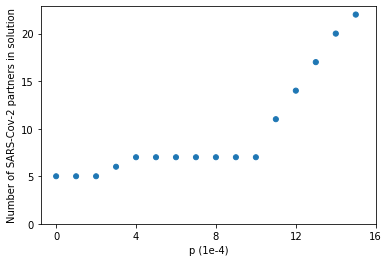

In [32]:
plt.figure()
plt.scatter(x = networks_summary_df['p'], 
            y = networks_summary_df['number_of_proteins_interacting_sars'],
            s = 0.1*networks_summary_df['nodes'])
plt.xlabel('p (1e-4)')
plt.ylabel('Number of SARS-Cov-2 partners in solution')
plt.xticks(np.arange(0,17,4),['0','4','8','12','16'])
plt.yticks(np.arange(0,25,5))
plt.show()

## Plot node stability heatmaps

<Figure size 432x288 with 0 Axes>

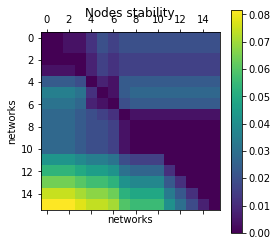

In [36]:
# Stability of selected nodes
mat_allnodes = svp.create_matrix_gene_overlap_between_networks(networks_summary_df, networks_dict)
plt.figure()
plt.matshow(mat_allnodes)
plt.xlabel('networks')
plt.ylabel('networks')
plt.title('Nodes stability')
plt.colorbar()
plt.show()

<Figure size 432x288 with 0 Axes>

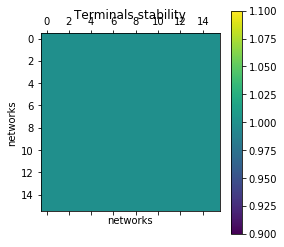

In [66]:
# Stability of selected terminals
mat_terminals = svp.create_matrix_terminal_overlap_between_networks(networks_summary_df, networks_dict)
plt.figure()
plt.matshow(mat_terminals)
plt.xlabel('networks')
plt.ylabel('networks')
plt.title('Terminals stability')
plt.colorbar()
plt.show()

<Figure size 432x288 with 0 Axes>

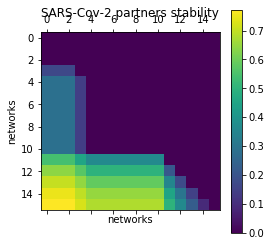

In [67]:
# Stability of selected SARS-Cov-2 partners
mat_sars = svp.create_matrix_sars_overlap_between_networks(networks_summary_df, networks_dict)
plt.figure()
plt.matshow(mat_sars)
plt.xlabel('networks')
plt.ylabel('networks')
plt.title('SARS-Cov-2 partners stability')
plt.colorbar()
plt.show()

## Select robust parameters

In [33]:
# Save network
index_selected = 8
paramstring_selected = networks_summary_df[networks_summary_df['index']==index_selected].index[0]
network_selected2 = networks_dict[paramstring_selected]

In [34]:
# Save selected network to file
oi.output_networkx_graph_as_interactive_html(network_selected2, filename="../Save_drop1/network_selected_sarspartners.html")
oi.output_networkx_graph_as_pickle(network_selected2, filename= '../Save_drop1/network_selected_sarspartners.pickle')
#oi.output_networkx_graph_as_graphml_for_cytoscape(network_selected, filename= r'../Save_drop1/network_selected_sarspartners.graphml')

PosixPath('/home/louiscam/projects/sars_cov_2/Save_drop1/network_selected_sarspartners.pickle')

# Add drug targets to selected network

## Construct drug/target data

In [19]:
# Compute degree centrality for all nodes in the interactome
graph = oi.Graph(interactome_file_name)
centrality_dic = nx.degree_centrality(graph.interactome_graph)

In [20]:
# Load drug/target data from DrugCentral
drug_target_file_name = '../Data/drug.target.interaction.tsv'
drugcentral_df = drugs2.load_drug_target_data(drug_target_file_name, aff_cst_thresh=5)
drugcentral_df['degree_centrality'] = [centrality_dic[gene] if (gene in list(centrality_dic.keys())) else None for gene in drugcentral_df['gene']]
drugcentral_df.head()

,gene,drug,protein_target,affinity_constant,affinity_constant_type,degree_centrality
0,SCN4A,levobupivacaine,Sodium channel protein type 4 subunit alpha,NaN,NaN,0.000635
1,CYP2D6,levobupivacaine,Cytochrome P450 2D6,6.706859,IC50,NaN
4,PTGER1,levobupivacaine,Prostaglandin E2 receptor EP1 subtype,NaN,NaN,0.000317
5,SCN1A,levobupivacaine,Sodium channel protein type 1 subunit alpha,5.790000,IC50,0.000254
6,KCNA5,levobupivacaine,Potassium voltage-gated channel subfamily A me...,NaN,NaN,0.002031


In [21]:
# Construct table that gives the number of targets per drug
num_targets_df0 = drugcentral_df.groupby('drug', as_index=False)[['gene']].agg({
    ('num_targets','count'),
    ('num_terminal_targets',lambda gs: len(set(gs).intersection(set(terminals))))
})
max_centrality_df0 = drugcentral_df.groupby('drug', as_index=False)[['degree_centrality']].agg({
    ('max_degree_centrality',max)
})
num_targets_df = pd.DataFrame({'drug': num_targets_df0.index,
                               'num_targets': num_targets_df0['gene']['num_targets'],
                               'num_terminal_targets': num_targets_df0['gene']['num_terminal_targets'],
                               'max_target_centrality': max_centrality_df0['degree_centrality']['max_degree_centrality']}).reset_index(drop=True)
num_targets_df = num_targets_df.sort_values(by='num_targets', ascending=False, inplace=False)
num_targets_df.head(10)

,drug,num_targets,num_terminal_targets,max_target_centrality
1830,sunitinib,260,4,0.055718
1369,nintedanib,218,3,0.037187
1269,midostaurin,204,3,0.055718
259,bosutinib,203,1,0.055718
474,crizotinib,148,3,0.055718
1735,ruxolitinib,132,1,0.027224
508,dasatinib,129,2,0.055718
1730,ruboxistaurin,121,1,0.055718
1795,sorafenib,116,4,0.037187
2031,vandetanib,109,3,0.055718


In [36]:
# Load L1000 drugs with correlations
embedded_drugs_file_name = '../Data/series16_cov_a549_dropped_genes_autoencoder_space.txt'
bestdrugs_df = pd.read_csv(embedded_drugs_file_name, header=None)
bestdrugs_df.columns = ['drug','corr']
bestdrugs_df['drug'] = bestdrugs_df['drug'].str.strip("()' ").str.lower()
bestdrugs_df['corr'] = pd.to_numeric(bestdrugs_df['corr'].str.strip("() "))
bestdrugs_df.sort_values(by='corr', axis=0, ascending=False, inplace=True)
#bestdrugs_df = bestdrugs_df.iloc[0:142] # so that we have the same number (142) of selected drugs as in the A549-SARS-Cov-2 analysis
bestdrugs_df.head()

,drug,corr
0,chloroquine,0.904594
1,menadione,0.900756
2,auranofin,0.897388
3,gemcitabine,0.878846
4,norepinephrine,0.873694


In [37]:
bestdrugs_df.loc[bestdrugs_df['drug']=='axitinib']

,drug,corr
365,axitinib,-0.708989


In [23]:
# Merge L1000 drugs with DrugCentral drug/target dataset
targets_and_drugs_df = drugcentral_df.merge(bestdrugs_df, on = 'drug', how = 'inner')
targets_and_drugs_df.head()

,gene,drug,protein_target,affinity_constant,affinity_constant_type,degree_centrality,corr
0,DNMT1,azacitidine,DNA (cytosine-5)-methyltransferase 1,NaN,NaN,0.005013,0.733548
1,DNMT3A,azacitidine,DNA (cytosine-5)-methyltransferase 3A,NaN,NaN,0.003363,0.733548
2,CYP1A2,methoxsalen,Cytochrome P450 1A2,7.39794,IC50,0.000127,0.298023
3,ACHE,methoxsalen,Acetylcholinesterase,6.12000,IC50,0.000888,0.298023
4,SOD2,acetylcysteine,"Superoxide dismutase [Mn], mitochondrial",NaN,NaN,0.003046,0.255687


## Add drug target information to selected network

In [24]:
network_selected = pickle.load(open('../Save_drop1/network_selected.pickle', "rb"))
network_selected = drugs2.add_drug_info_to_selected_network(network_selected, targets_and_drugs_df)
# Save enriched network as pickle
oi.output_networkx_graph_as_pickle(network_selected, filename= '../Save_drop1/network_selected_with_drug_info.pickle')

PosixPath('/home/louiscam/projects/sars_cov_2/Save_drop1/network_selected_with_drug_info.pickle')

In [25]:
# Construct table of drug targets in the network
drug_targets_df = drugs2.drug_targets_in_selected_network(network_selected)
drug_targets_df.to_csv(r'../Save_drop1/drug_targets_in_network.tsv', header=True, index=None, sep='\t', quoting = csv.QUOTE_NONE, escapechar = '\t')
drug_targets_df['affinity'] = pd.to_numeric(drug_targets_df['affinity'], errors='coerce')
drug_targets_df.dropna(subset=['affinity'], inplace=True)
drug_targets_df

,name,protein_target,drug,corr,affinity
ACVR2A,ACVR2A,{Activin receptor type-2A},dasatinib,-0.018264063,6.680000
AURKC,AURKC,{Aurora kinase C},erlotinib,0.5696074000000001,6.220000
AURKC,AURKC,{Aurora kinase C},pazopanib,0.27783695,6.120000
AURKC,AURKC,{Aurora kinase C},crizotinib,0.78411055,5.370000
EGFR,EGFR,{Epidermal growth factor receptor},dasatinib,-0.018264063,7.100000
EGFR,EGFR,{Epidermal growth factor receptor},erlotinib,0.5696074000000001,9.220000
EGFR,EGFR,{Epidermal growth factor receptor},gefitinib,0.07047932,9.400000
EGFR,EGFR,{Epidermal growth factor receptor},crizotinib,0.78411055,5.570000
EGFR,EGFR,{Epidermal growth factor receptor},cisplatin,0.18955152,5.581533
FGFR1,FGFR1,{Fibroblast growth factor receptor 1},dasatinib,-0.018264063,5.430000


In [26]:
# Save drug/target dataframe to csv
drug_targets_df.to_csv(r'../Save_drop1/final_drug_target_table.tsv', header=True, index=None, sep='\t', quoting = csv.QUOTE_NONE, escapechar = '\t')

In [27]:
# More details on selected drugs
num_targets_df.loc[num_targets_df['drug'].isin(np.unique(drug_targets_df['drug']))]

,drug,num_targets,num_terminal_targets,max_target_centrality
474,crizotinib,148,3,0.055718
508,dasatinib,129,2,0.055718
1479,pazopanib,104,3,0.028430
719,erlotinib,96,2,0.055718
884,gefitinib,72,1,0.055718
1364,nilotinib,70,0,0.028430
1771,sildenafil,21,1,0.002538
424,cisplatin,13,0,0.055718
1403,olaparib,4,1,0.014152


# Compare to analysis without dropping the genes

In [34]:
# Drug/target dataframe in the original case
drug_targets_df_original_file_name = '../Save/final_drug_target_table.tsv'
drug_targets_df_original = pd.read_csv(drug_targets_df_original_file_name, sep = '\t')
drug_targets_df_original

,name,protein_target,drug,corr,affinity
0,ACVR2A,{'Activin receptor type-2A'},dasatinib,0.882561,6.6800
1,AURKC,{'Aurora kinase C'},erlotinib,0.873780,6.2200
2,AURKC,{'Aurora kinase C'},sorafenib,0.865171,6.6800
3,AURKC,{'Aurora kinase C'},sunitinib,0.868590,6.6600
4,AURKC,{'Aurora kinase C'},pazopanib,0.866959,6.1200
5,AURKC,{'Aurora kinase C'},ruxolitinib,0.874877,5.0600
6,AURKC,{'Aurora kinase C'},axitinib,0.877977,8.8900
7,BRSK1,{'Serine/threonine-protein kinase BRSK1'},sunitinib,0.868590,5.4600
8,CDK17,{'Cyclin-dependent kinase 17'},sorafenib,0.865171,5.8000
9,CDK17,{'Cyclin-dependent kinase 17'},sunitinib,0.868590,5.9200


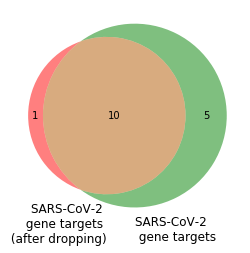

['PARP1']
['ACVR2A', 'AURKC', 'EGFR', 'FGFR1', 'FGFR3', 'IRAK1', 'PDE4B', 'RIPK1', 'RIPK2', 'STK3']
['BRSK1', 'CDK17', 'HDAC1', 'HSP90AA1', 'PAK1']


In [32]:
# Common gene targets
targets_drop1 = set(drug_targets_df['name'])
targets_original = set(drug_targets_df_original['name'])

# plot Venn diagram SARS-CoV-2-Drop1 vs SARS-CoV-2
plt.figure()
venn2(subsets = [targets_drop1,targets_original],
      set_labels = ('SARS-CoV-2 \n gene targets \n (after dropping)','SARS-CoV-2 \n gene targets'),
      set_colors=('r', 'g'), 
      alpha = 0.5)
#venn2_circles(subsets = [targets_drop1,targets_a549])
plt.savefig('../Save_drop1/venn2_drop1_sars_genes.pdf', format='pdf')
plt.show()

print(sorted(targets_drop1.difference(targets_original)))
print(sorted(targets_drop1.intersection(targets_original)))
print(sorted(targets_original.difference(targets_drop1)))

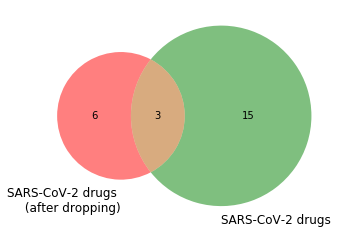

['afatinib', 'axitinib', 'belinostat', 'bosutinib', 'docetaxel', 'formoterol', 'imatinib', 'milrinone', 'primaquine', 'ruxolitinib', 'sorafenib', 'sunitinib', 'tofacitinib', 'vardenafil', 'vorinostat']
['cisplatin', 'crizotinib', 'gefitinib', 'nilotinib', 'olaparib', 'sildenafil']
['dasatinib', 'erlotinib', 'pazopanib']


In [33]:
# Common drugs
drugs_drop1 = set(drug_targets_df['drug'])
drugs_original = set(drug_targets_df_original['drug'])

# plot Venn diagram SARS-CoV-2-Drop1 vs SARS-CoV-2
plt.figure()
venn2(subsets = [drugs_drop1,drugs_original],
      set_labels = ('SARS-CoV-2 drugs \n (after dropping)','SARS-CoV-2 drugs'),
      set_colors=('r', 'g'), 
      alpha = 0.5)
plt.savefig('../Save_drop1/venn2_drop1_sars_drugs.pdf', format='pdf')
plt.show()

a549_minus_drop1 = num_targets_df.loc[num_targets_df['drug'].isin(drugs_original.difference(drugs_drop1))]
drop1_minus_a549 = num_targets_df.loc[num_targets_df['drug'].isin(drugs_drop1.difference(drugs_original))]
a549_inter_drop1 = num_targets_df.loc[num_targets_df['drug'].isin(drugs_original.intersection(drugs_drop1))]

print(sorted(set(a549_minus_drop1['drug'])))
print(sorted(set(drop1_minus_a549['drug'])))
print(sorted(set(a549_inter_drop1['drug'])))